In [ ]:
!pip3 install pycuda

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 61kB 21.2MB/s 
     |████████████████████████████████| 471kB 41.3MB/s 
  Created wheel for pycuda: filename=pycuda-2019.1.2-cp36-cp36m-linux_x86_64.whl size=4536213 sha256=39889e6c34386f5706e18df6b0db75f805c6662bffd12a245f7b655cf58de3ff
  Stored in directory: /root/.cache/pip/wheels/a6/60/f0/b1c430c73d281ac3e46070480db50f7907364eb6f6d3188396
  Created wheel for pytools: filename=pytools-2019.1.1-py2.py3-none-any.whl size=58424 sha256=742257943ab152e49daea8bf2264f2eefab7da042703cd19aad209a18ba3af9f
  Stored in directory: /root/.cache/pip/wheels/83/df/0b/75ac4572aaa93e3eba6a58472635d0fda907f5f4cf884a3a0c
  Created wheel for mako: filename=Mako-1.1.0-cp36-none-any.whl size=75363 sha256=b1c2344ea685ad838a5eba91704e5bc366dee55f9cf752fd792d5e938acb6e13
  Stored in directory: /root/.cache/pip/wheels/98/32/7b/a291926643fc1d1e02593e0d9e247c5a866a366b8343b7aa27
Successfully built pycuda pytools mako


In [ ]:
import math
import numpy as np
import pycuda.gpuarray as gpuarray
from pycuda.compiler import SourceModule
import pycuda.autoinit
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
module = SourceModule("""
#include <pycuda-complex.hpp>
__global__ void mandel_kernel(int nx, int ny, float *real_val, float *imag_val, float *res,
int max_iter, float upper_bound){
    int x = threadIdx.x + blockDim.x * blockIdx.x;
    int y = threadIdx.y + blockDim.y * blockIdx.y;
    int ij = nx * y + x;
    if (x < nx && y < ny){
        int diverge_flag = 0;
        pycuda::complex<float> c(real_val[ij], imag_val[ij]);
        pycuda::complex<float> z(0, 0);
        for (int i = 0; i < max_iter; i++){
            z = z * z + c;
            if (abs(z) > upper_bound){
                res[ij] = (float) i;
                diverge_flag = 1;
                break;
            }
        }
        if (diverge_flag == 0){
            res[ij] = (float) max_iter;
        }
    }
}
""")

In [ ]:
mandelbrot = module.get_function("mandel_kernel")

In [ ]:
nx = np.int32(500)
ny = np.int32(1000)
max_iter = np.int32(100)
upper_bound = np.float32(2.0)

In [ ]:
x = np.linspace(-2, 2, nx, dtype=np.float32)
y = np.linspace(-2, 2, ny, dtype=np.float32)

In [ ]:
Y, X = np.meshgrid(y, x, indexing="ij")

In [ ]:
X_gpu = gpuarray.to_gpu(X)
Y_gpu = gpuarray.to_gpu(Y)

In [ ]:
res_gpu = gpuarray.zeros([ny, nx], dtype=np.float32)

In [ ]:
threads_per_block = (16, 16, 1)
block_x = math.ceil(nx / threads_per_block[0])
block_y = math.ceil(ny / threads_per_block[1])
blocks_per_grid = (block_x, block_y, 1)

In [ ]:
mandelbrot(nx, ny, X_gpu, Y_gpu, res_gpu, max_iter, upper_bound, block=threads_per_block, grid=blocks_per_grid)

In [ ]:
res = res_gpu.get()

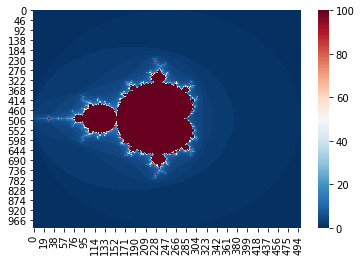

In [ ]:
sns.heatmap(res, cmap="RdBu_r")
plt.show()